# 1. basic

# 2. import libs

In [38]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib import patches as patches
import cv2


In [39]:
import os
import shutil as sh

from pathlib import Path
import re
from tqdm import tqdm

import torch

import warnings 
warnings.simplefilter("ignore")

import seaborn as sns
import sys


In [40]:
sys.path.insert(0, "malaria/weightedboxesfusion/")
from ensemble_boxes import *


from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from sklearn.model_selection import train_test_split

import io
import base64

import time
from IPython.display import clear_output
from IPython.display import HTML

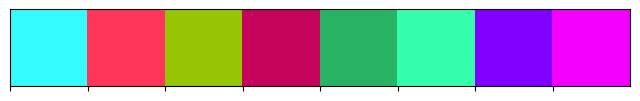

In [41]:
custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [42]:
def plot_data_example(df: pd.DataFrame,
                      root_dir: str,
                      img_path: str, 
                      colors: dict):

    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = np.zeros(image.shape, dtype="uint8")

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 8))
    ax[1].imshow(image, aspect="auto")
    ax[1].set_title("Original Image", fontsize=22, fontweight='bold', y=1.07)
    ax[0].set_title("Image with Bounding Boxes", fontsize=22, fontweight='bold', y=1.07)


    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]

        ax[0].add_patch(bbox)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        ax[0].imshow(image, aspect="auto")
        ax[0].imshow(boxes,  alpha=0.3, aspect="auto")
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    fig.savefig("data_exemple1.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
    fig.savefig("data_exemple1.png", format='png', bbox_inches='tight', pad_inches=0.2)
    plt.show()


def plot_image_with_bb(df: pd.DataFrame,
                       root_dir: str,
                       img_path: str,
                       path_to_save: str, 
                       dpi: float=100, 
                       write: bool=True):
    
    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = np.zeros(image.shape, dtype="uint8")
    h, w, _ = image.shape
    figsize = (w / dpi), (h / dpi)

    fig, ax = plt.subplots(sharey=True, figsize=(figsize))
    fig.add_axes([0, 0, 1, 1])
 
    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]
        ax = plt.gca()
        ax.add_patch(bbox)
        plt.text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        plt.imshow(image, aspect="auto")
        plt.imshow(boxes,  alpha=0.3, aspect="auto")
        plt.text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    #plt.axis("off")                                            ## dont work in kaggle kernel
    fig.axes[0].get_xaxis().set_visible(False)                  ## work in kaggle kernel
    fig.axes[0].get_yaxis().set_visible(False)

    if write:
        img_name = img_path.replace('/', '.').split('.')[-2]
        #fig.savefig(f"{path_to_save}/{img_name}.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
        fig.savefig(f"{path_to_save}/{img_name}.png", format='png', bbox_inches='tight', pad_inches=0.0)
        plt.close()
    else:
        plt.show()
  

def plot_sample(image: torch.Tensor,
                boxes: torch.Tensor, 
                labels: torch.Tensor):
    boxes = boxes.cpu().numpy().astype(np.int32)
    labels = labels.cpu().numpy().astype(np.int32)
    image = image.permute(1,2,0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    masks = np.zeros_like(image)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for label, box in zip(labels, boxes):
        color = label2rgb[label]
        text = label2category[label]
        cmin, rmin, cmax, rmax = box

        cv2.rectangle(image,
                    (cmin, rmin),
                    (cmax, rmax),
                    color=color, thickness=3,)
        cv2.putText(image, text, (cmin, rmin), cv2.FONT_HERSHEY_SIMPLEX, 1,  
                    color, 3, cv2.LINE_AA, False,) 
        
        masks[rmin:rmax, cmin:cmax] = color

    image_with_masks = cv2.addWeighted(image, 0.7, masks, 0.7, 0)
    ax.set_axis_off()
    ax.imshow(image_with_masks)

    
def create_video(path_to_imgs: str, video_name: str, framerate: int):
    """
    Create video from images.
    Params:
        path_to_imgs: path to dir with images.
        video_name: name for saving video.
        framerate: num frames per sec in video.
    """
    frame_width, frame_height = 1600, 1200
    img_names = sorted(os.listdir(path_to_imgs))
    img_path = os.path.join(path_to_imgs, img_names[0])

    fourc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(video_name + ".avi", 
                            fourc, 
                            framerate, 
                            (frame_width, frame_height))

    for img_name in img_names:
        img_path = os.path.join(path_to_imgs, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (frame_width, frame_height))
        video.write(image)
            
    cv2.destroyAllWindows()
    video.release()
    
def show_video(video_path: str):
    """
    show video in jupyter notebook, agent interaction in environment.
    Takes - path to video file.
    Returns - html video player in jupyter notebook.
    """  
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    return HTML(data='''<video alt="test" width="800" height="400" controls> 
    <source src="data:video/mp4;base64,{0}" type="video/mp4" /"> </video>'''
    .format(encoded.decode('ascii')))

In [43]:
class GlobalConfig:
        root_dir = 'malaria/'
        train_json_path = 'malaria/training.json'
        test_json_path = 'malaria/test.json'
        yolo_weights = 'malaria/yolov5x_malaria.pt'
        fasterrcnn_weights = 'malaria/fasterrcnn_resnet50_fpn.pth'
        seed = 33
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

# 3. Data Preparation

In [44]:
train_df = pd.read_json(config.train_json_path)
test_df = pd.read_json(config.test_json_path)
print(train_df.shape, test_df.shape)

(1208, 2) (120, 2)


In [45]:
train_df.head()

,image,objects
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':..."
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."


In [46]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)# 矩阵拼接
df.head()

,image,objects
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':..."
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."


In [47]:
df.shape

(1328, 2)

In [48]:
print(df['image'].sample().values, "\n",#
      df['objects'].sample().values)

[{'checksum': 'e67761e9c465c2604242bbbad72ca7aa', 'pathname': '/images/1b7f47fc-26cd-4273-b848-88a7cbfd9f85.png', 'shape': {'r': 1200, 'c': 1600, 'channels': 3}}] 
 [list([{'bounding_box': {'minimum': {'r': 477, 'c': 549}, 'maximum': {'r': 578, 'c': 673}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 275, 'c': 908}, 'maximum': {'r': 391, 'c': 1024}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 177, 'c': 393}, 'maximum': {'r': 297, 'c': 514}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 975, 'c': 975}, 'maximum': {'r': 1101, 'c': 1108}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 275, 'c': 1089}, 'maximum': {'r': 379, 'c': 1222}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 848, 'c': 439}, 'maximum': {'r': 967, 'c': 557}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 915, 'c': 1376}, 'maximum': {'r': 1036, 'c': 1497}}, 'category': 'red blood cell'}, {'boundi

In [49]:
# future: plot bounding box to display more details

In [50]:
df.shape

(1328, 2)

In [51]:
# 在 dataframe 种添加新的3列
df["checksum"] = df['image'].apply(lambda x: x["checksum"])
df["pathname"] = df['image'].apply(lambda x: x["pathname"][1:])
df["shape"] = df['image'].apply(lambda x: x["shape"])
df.head()

,image,objects,checksum,pathname,shape
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':...",676bb8e86fc2dbf05dd97d51a64ac0af,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ...",1225a18efce159eddf7b0e80e0ea642c,images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ...",3eaf840523c30fdf38897ffa01e194eb,images/6b14c855-8561-417c-97a4-63fa552842fd.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ...",8a111dffacfa433029492780b9535091,images/13099edb-35d9-438f-b093-2cf2ebf9d255.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ...",ccef403e971460b86444cca669e68ca1,images/2559636b-f01a-4414-93da-210c3b12d153.png,"{'r': 1200, 'c': 1600, 'channels': 3}"


In [52]:
df.shape

(1328, 5)

In [53]:
# 每个bound_box都取出来作为单独的一行
# 该操作会扩大dataframe的行数
df = pd.DataFrame(
    [
     dict(pathname=row['pathname'], 
          shape=row['shape'],
          checksum=row['checksum'],
          **bb_info) 
     for _, row in df.iterrows() 
     for bb_info in row['objects']
     ]
     )
df.shape

(85589, 5)

In [54]:
df.head()

,pathname,shape,checksum,bounding_box,category
0,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 1057, 'c': 1440}, 'maximum':...",red blood cell
1,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 868, 'c': 1303}, 'maximum': ...",red blood cell
2,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 578, 'c': 900}, 'maximum': {...",red blood cell
3,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 304, 'c': 611}, 'maximum': {...",red blood cell
4,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 198, 'c': 881}, 'maximum': {...",red blood cell


In [55]:
# 定义一个行数，将list中的数据取出来
def extract_nested_list(it):
    if isinstance(it, list):
        for sub_it in it:
            yield from extract_nested_list(sub_it)
    elif isinstance(it, dict):
        for value in it.values():
            yield from extract_nested_list(value)
    else:
        yield it

In [56]:
# 在dataframe中，增加更多行数，列数不变
df['x_min'] = -1
df['y_min'] = -1
df['x_max'] = -1
df['y_max'] = -1

df[['y_min', 'x_min', 'y_max', 'x_max']] = np.stack(df['bounding_box'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df.drop(columns=['bounding_box'], inplace=True)
df['x_min'] = df['x_min'].astype(np.float)
df['y_min'] = df['y_min'].astype(np.float)
df['x_max'] = df['x_max'].astype(np.float)
df['y_max'] = df['y_max'].astype(np.float)

df['w'] = df['x_max'] - df['x_min']
df['h'] = df['y_max'] - df['y_min']

df['x_center'] = df['x_min'] + df['w'] / 2
df['y_center'] = df['y_min'] + df['h'] / 2

In [57]:
df.shape

(85589, 12)

In [58]:
df.head()

,pathname,shape,checksum,category,x_min,y_min,x_max,y_max,w,h,x_center,y_center
0,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1440.0,1057.0,1540.0,1158.0,100.0,101.0,1490.0,1107.5
1,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1303.0,868.0,1403.0,971.0,100.0,103.0,1353.0,919.5
2,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,900.0,578.0,1008.0,689.0,108.0,111.0,954.0,633.5
3,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,611.0,304.0,713.0,408.0,102.0,104.0,662.0,356.0
4,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,881.0,198.0,1003.0,312.0,122.0,114.0,942.0,255.0


In [59]:
# 在dataframe中，增加更多行数，列数不变

df['img_width'] = -1
df['img_height'] = -1
df['channels'] = -1
df['pixels'] = -1

df[['img_height','img_width', 'channels']] = np.stack(df['shape'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df.drop(columns=['shape'], inplace=True)
df['pixels'] = df['img_width'] * df['img_height'] * df['channels']


In [60]:
df.shape

(85589, 15)

In [61]:
cat_dict = {v:k for k,v in enumerate(df['category'].value_counts().index, 0)}
df["label"] = df["category"].map(cat_dict)
print(df.shape)

(85589, 16)


# 4. EDA (Explorotary Data Analysis)

In [62]:
df['category'].value_counts()


red blood cell    83034
trophozoite        1584
ring                522
schizont            190
gametocyte          156
leukocyte           103
Name: category, dtype: int64

In [63]:
df.head(5)

,pathname,checksum,category,x_min,y_min,x_max,y_max,w,h,x_center,y_center,img_width,img_height,channels,pixels,label
0,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1440.0,1057.0,1540.0,1158.0,100.0,101.0,1490.0,1107.5,1600,1200,3,5760000,0
1,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1303.0,868.0,1403.0,971.0,100.0,103.0,1353.0,919.5,1600,1200,3,5760000,0
2,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,900.0,578.0,1008.0,689.0,108.0,111.0,954.0,633.5,1600,1200,3,5760000,0
3,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,611.0,304.0,713.0,408.0,102.0,104.0,662.0,356.0,1600,1200,3,5760000,0
4,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,881.0,198.0,1003.0,312.0,122.0,114.0,942.0,255.0,1600,1200,3,5760000,0


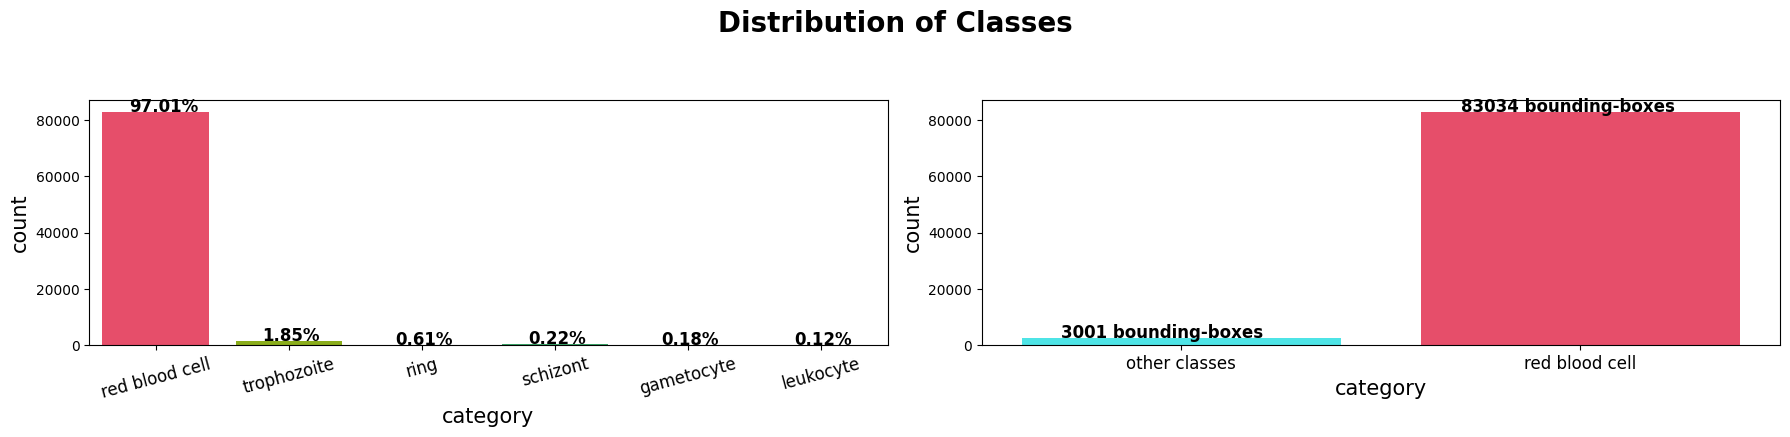

In [64]:
percentages = [c / df.shape[0] * 100 for c in df['category'].value_counts()]
df['Are there red blood cells in the Image?'] = df['category'] == 'red blood cell'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
#sns.countplot(df['category'], ax=ax[0],  palette=custom_colors[1:])
sns.countplot(x='category',data=df, ax=ax[0],  palette=custom_colors[1:])
#sns.countplot(df['Are there red blood cells in the Image?'], ax=ax[1], palette=custom_colors)
sns.countplot(x='Are there red blood cells in the Image?',data=df, ax=ax[1], palette=custom_colors)

ax[0].set_xticklabels(df['category'].value_counts().index, fontsize=12, rotation=15)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=15)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=15)

ax[1].set_xticklabels(['other classes', 'red blood cell'], fontsize=12, rotation=0)
ax[1].set_xlabel('category', fontsize=15)
ax[1].set_ylabel(ax[1].get_ylabel(), fontsize=15)

for percentage, p in zip(percentages, ax[0].patches):
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.2
    y = p.get_y() + p.get_height()
    ax[0].annotate(percentage, (x, y), fontsize=12, fontweight='bold')

for percentage, p in zip([3001, 83034], ax[1].patches):
    percentage = f'{percentage} bounding-boxes'
    x = p.get_x() + p.get_width() / 2 - 0.3
    y = p.get_y() + p.get_height()
    ax[1].annotate(percentage, (x, y), fontsize=12, fontweight='bold')

plt.suptitle("Distribution of Сlasses", y=1.08, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig(f"class_dist.svg", format="svg", bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"class_dist.png", format="png", bbox_inches='tight', pad_inches=0.2)

df.drop(columns=['Are there red blood cells in the Image?'], inplace=True)


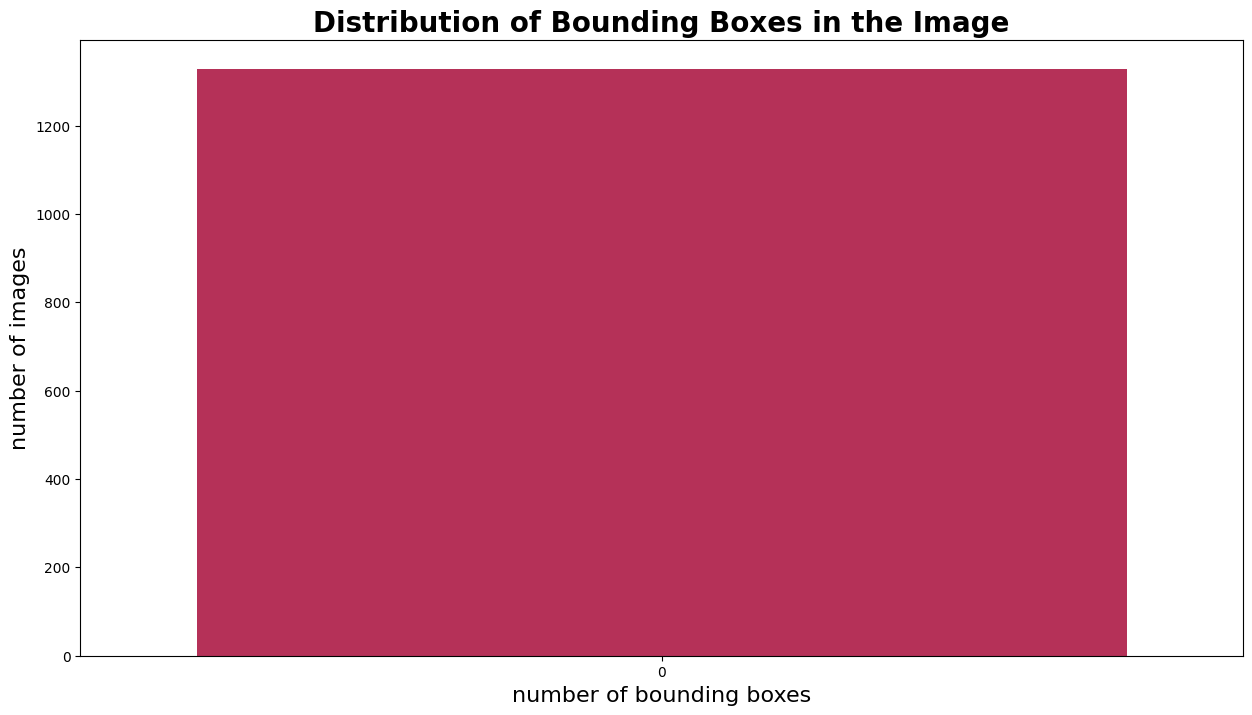

In [65]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df.groupby('pathname')['checksum'].count(), ax=ax, palette='rocket')
ax.set_xticks(ax.get_xticks()[::3]);
ax.set_ylabel('number of images', fontsize=16)
ax.set_xlabel('number of bounding boxes', fontsize=16)
ax.set_title("Distribution of Bounding Boxes in the Image", fontsize=20, fontweight='bold');
fig.savefig("bb-dist.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
fig.savefig("bb-dist.png", format='png', bbox_inches='tight', pad_inches=0.2)


In [66]:
df.shape

(85589, 16)

In [67]:
image_dimensions = df.drop_duplicates(subset=['pathname']).groupby(['img_width', 'img_height', 'channels']).count()['pathname'].to_dict()
image_dimensions

{(1600, 1200, 3): 1208, (1944, 1383, 3): 120}

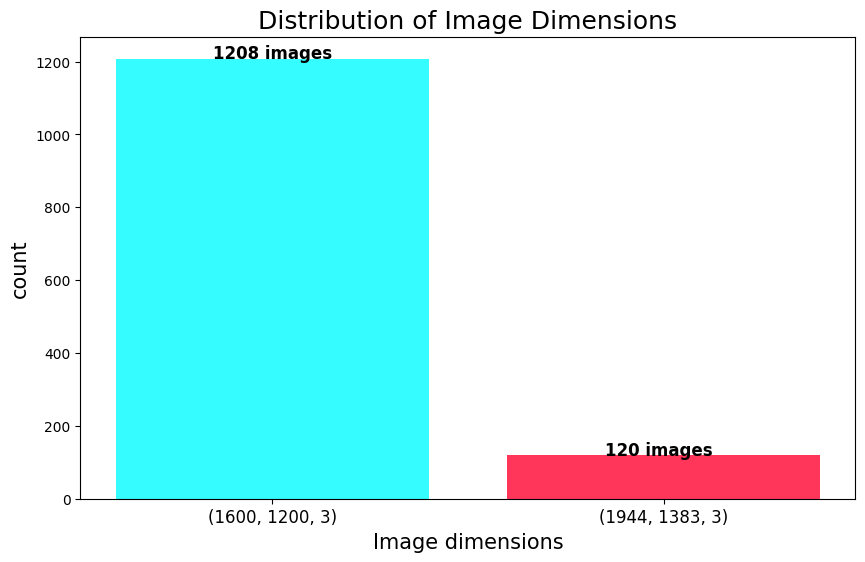

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(np.arange(len(image_dimensions)), image_dimensions.values(), color=custom_colors)
ax.set_xticks(np.arange(len(image_dimensions)))
ax.set_xticklabels(image_dimensions, fontsize=12)
ax.set_xlabel("Image dimensions", fontsize=15)
ax.set_ylabel("count", fontsize=15)
ax.set_title("Distribution of Image Dimensions", fontsize=18)

for percentage, p in zip(image_dimensions.values(), ax.patches):
    percentage = f'{percentage} images'
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage), (x, y), fontsize=12, fontweight='bold')


In [ ]:
img_path = df["pathname"].sample(1).values[0]

label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}
label2rgb = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), rgbcolors)}

plot_data_example(df, config.root_dir, img_path, colors=label2hex)


# 5. YoloV5

In [ ]:
df.head()

In [ ]:
df['w_yolo'] = df[['w', 'img_width']].apply(lambda x: x[0] / x[1], axis=1)
df['h_yolo'] = df[['h', 'img_height']].apply(lambda x: x[0] / x[1], axis=1)
df['x_center_yolo'] = df[['x_center', 'img_width']].apply(lambda x: x[0] / x[1], axis=1)
df['y_center_yolo'] = df[['y_center', 'img_height']].apply(lambda x: x[0] / x[1], axis=1)

In [ ]:
yolov5_df = df.copy()
yolov5_df = yolov5_df[yolov5_df["pathname"].apply(lambda x: x[-4:] == '.png')].reset_index(drop=True)
yolov5_df["name"] = yolov5_df["pathname"].apply(lambda x: x.split("/")[-1].split(".")[0])
yolov5_df.head()

In [ ]:
index = list(set(yolov5_df.name))

In [ ]:
source = "images"
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name, mini in tqdm(yolov5_df.groupby('name')):
            if name in val_index:
                path2save = 'val2017/'
                #print("val")
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['label','x_center_yolo', 'y_center_yolo', 'w_yolo', 'h_yolo']].astype(float).values
                #print(row)
                #row = row[0:]/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("malaria/{}/{}.png".format(source,name),'convertor/fold{}/images/{}/{}.png'.format(fold,path2save,name))

In [ ]:
!python \
 train.py \
 --img 512 \
 --batch 12 \
 --epochs 2 \
 --data /home/ubuntu/project2/malaria/malaria_conf.yaml \
 --cfg /home/ubuntu/project2/malaria/yolov5x.yaml \
 --weights '' \
 --name yolov5x_malaria 

In [38]:
%%bash
git clone -b v1.0 https://github.com/ultralytics/yolov5 -qq


fatal: destination path 'yolov5' already exists and is not an empty directory.


CalledProcessError: Command 'b'git clone -b v1.0 https://github.com/ultralytics/yolov5 -qq\n'' returned non-zero exit status 128.

In [42]:
%%bash
mv -f yolov5/* ./


%%bash
pip install -r requirements.txt -qq

**注意：这条命令必须要在CMD里运行，运行后会在weight/目录下生成新模型**
```
!python \
 train.py \
 --img 512 \
 --batch 12 \
 --epochs 2 \
 --data /home/malaria/malaria_conf.yaml \
 --cfg /home/malaria/yolov5x.yaml \
 --name yolov5x_malaria 
 ```

In [83]:
!python \
 train.py \
 --img 512 \
 --batch 512 \
 --epochs 1 \
 --data /home/malaria/malaria_conf.yaml \
 --cfg /home/malaria/yolov5x.yaml \
 --weights '' \
 --name yolov5x_malaria 

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
check_file= /home/malaria/yolov5x.yaml
check_file= /home/malaria/malaria_conf.yaml
Namespace(adam=False, batch_size=12, bucket='', cache_images=False, cfg='/home/malaria/yolov5x.yaml', data='/home/malaria/malaria_conf.yaml', device='', epochs=1, evolve=False, img_size=[512], multi_scale=False, name='yolov5x_malaria', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15109MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

              from  n    params  module      

In [ ]:
python \
 train.py \
 --img 512 \
 --batch 12 \
 --epochs 2 \
 --data /home/ubuntu/project2/malaria/malaria_conf.yaml \
 --cfg /home/ubuntu/project2/malaria/yolov5x.yaml \
 --weights '' \
 --name yolov5x_malaria 

In [50]:
import argparse

from utils.datasets import *
from utils.utils import *


def detect(save_img=False):
    weights, imgsz = opt.weights,opt.img_size
    source = 'convertor/fold0/images/val2017'
    
    # Initialize
    device = torch_utils.select_device(opt.device)
    half = False
    # Load model

    model = torch.load(weights, map_location=device)['model'].to(device).float().eval()

    dataset = LoadImages(source, img_size=1024)

    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    all_path=[]
    all_bboxex =[]
    all_score =[]
    all_labels = []
    for path, img, im0s, vid_cap in dataset:
        print(im0s.shape)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        bboxes_2 = []
        score_2 = []
        label_2 = []
        if True:
            pred = model(img, augment=opt.augment)[0]
            pred = non_max_suppression(pred, 0.4, opt.iou_thres, classes=None, agnostic=False)
            t2 = torch_utils.time_synchronized()

            bboxes = []
            score = []
            label = []
            # Process detections
            for i, det in enumerate(pred):  # detections per image
                p, s, im0 = path, '', im0s
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
                if det is not None and len(det):
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class

                    for *xyxy, conf, cls in det:
                        if True:  # Write to file
                            xywh = torch.tensor(xyxy).view(-1).numpy()  # normalized xywh
#                             xywh[2] = xywh[2]-xywh[0]
#                             xywh[3] = xywh[3]-xywh[1]
                            bboxes.append(xywh)
                            score.append(conf)
                            label.append(cls)
            bboxes_2.append(bboxes)
            score_2.append(score)
            label_2.append(label)
        all_path.append(path)
        all_score.append(score_2)
        all_bboxex.append(bboxes_2)
        all_labels.append(label_2)
    return all_path,all_score,all_bboxex, all_labels


if __name__ == '__main__':
    class opt:
        weights = config.yolo_weights
        img_size = 1024
        conf_thres = 0.4
        iou_thres = 0.5
        augment = True
        device = 'gpu'
        classes=None
        agnostic_nms = True
        
    opt.img_size = check_img_size(opt.img_size)
    print(opt)

    with torch.no_grad():
        res = detect()

<class '__main__.opt'>
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15109MB)

image 1/707 convertor/fold0/images/val2017/002f20ad-2ace-499c-9335-c9080bc3e6b5.png: (1200, 1600, 3)
image 2/707 convertor/fold0/images/val2017/00a02700-2ea2-4590-9e15-ffc9160fd3de.png: (1200, 1600, 3)
image 3/707 convertor/fold0/images/val2017/00d04a90-80e5-4bce-9511-1b64eabb7a47.png: (1200, 1600, 3)
image 4/707 convertor/fold0/images/val2017/0154dd8e-72f8-4d78-a4dd-93e139577bd1.png: (1200, 1600, 3)
image 5/707 convertor/fold0/images/val2017/01b99da8-b66b-464b-a7ee-1cadab8db18b.png: (1200, 1600, 3)
image 6/707 convertor/fold0/images/val2017/027ab174-e47a-44f8-b85b-372449eeb7d8.png: (1200, 1600, 3)
image 7/707 convertor/fold0/images/val2017/02ea7aa8-c142-4a3d-939f-e77689741341.png: (1200, 1600, 3)
image 8/707 convertor/fold0/images/val2017/03359d4d-69cb-4146-8286-ca7399366f97.png: (1200, 1600, 3)
image 9/707 convertor/fold0/images/val2017/034c8d57-04d5-4786-93a4-6ae8fde2c258.png: (12

image 81/707 convertor/fold0/images/val2017/1e86933d-6a5a-4a3c-a0f2-ca22afd767b3.png: (1200, 1600, 3)
image 82/707 convertor/fold0/images/val2017/1e978dfa-d339-4025-809d-09cee76728ed.png: (1200, 1600, 3)
image 83/707 convertor/fold0/images/val2017/1ecb0405-a6e9-4485-819e-2fbbf2b718aa.png: (1200, 1600, 3)
image 84/707 convertor/fold0/images/val2017/1f337b61-1b0d-4539-91f9-73d4a0798a4a.png: (1200, 1600, 3)
image 85/707 convertor/fold0/images/val2017/1f8edb2a-40bc-4beb-aa6b-884d2473df0f.png: (1200, 1600, 3)
image 86/707 convertor/fold0/images/val2017/1f8f08ea-b5b3-4f68-94d4-3cc071b7dce8.png: (1200, 1600, 3)
image 87/707 convertor/fold0/images/val2017/1fe1e118-adb8-4b10-a41e-1e5814e8f067.png: (1200, 1600, 3)
image 88/707 convertor/fold0/images/val2017/20d4f65e-6c63-433a-935c-d568d577967b.png: (1200, 1600, 3)
image 89/707 convertor/fold0/images/val2017/21417261-475a-456f-b03f-57ac85a6e106.png: (1200, 1600, 3)
image 90/707 convertor/fold0/images/val2017/214f1d15-a081-476e-992d-6c3a77f03d59.p

image 161/707 convertor/fold0/images/val2017/3b601a1b-26d8-4873-afcf-fdd1b1e0010c.png: (1200, 1600, 3)
image 162/707 convertor/fold0/images/val2017/3d1b889e-bb4a-4ee6-b899-974ee7d956a7.png: (1200, 1600, 3)
image 163/707 convertor/fold0/images/val2017/3d8fb5bf-3315-48fb-8ab1-802eafd550bc.png: (1200, 1600, 3)
image 164/707 convertor/fold0/images/val2017/3dcd4f1b-ce43-4a34-b1ed-076bb42963b1.png: (1200, 1600, 3)
image 165/707 convertor/fold0/images/val2017/3e753a44-3264-438c-8389-a7822e4a84cc.png: (1200, 1600, 3)
image 166/707 convertor/fold0/images/val2017/3e764461-22ee-44d3-925d-cd658ff7d154.png: (1200, 1600, 3)
image 167/707 convertor/fold0/images/val2017/3eba916c-998b-40a7-993c-7ed916c2a04c.png: (1200, 1600, 3)
image 168/707 convertor/fold0/images/val2017/3f8c5ae1-b9fd-464b-8e91-98143ddd8d29.png: (1200, 1600, 3)
image 169/707 convertor/fold0/images/val2017/406e05f0-4444-414c-bb40-f4cb08e75ac9.png: (1200, 1600, 3)
image 170/707 convertor/fold0/images/val2017/412c9fa5-fcf4-402b-b1e4-3271

image 241/707 convertor/fold0/images/val2017/5a043d69-f435-46d4-8691-395c1602a76a.png: (1200, 1600, 3)
image 242/707 convertor/fold0/images/val2017/5a0628af-4c0a-4ba6-a935-4ec94c9c700e.png: (1200, 1600, 3)
image 243/707 convertor/fold0/images/val2017/5a105b89-c592-4d78-b208-7db6c6572752.png: (1200, 1600, 3)
image 244/707 convertor/fold0/images/val2017/5a386082-397f-4524-a6f9-c2b8efe5014d.png: (1200, 1600, 3)
image 245/707 convertor/fold0/images/val2017/5c5b7965-1a44-44b8-aa43-660823e61821.png: (1200, 1600, 3)
image 246/707 convertor/fold0/images/val2017/5c68070c-3391-4db6-8c01-94175105dbea.png: (1200, 1600, 3)
image 247/707 convertor/fold0/images/val2017/5c99cd97-39f6-4809-9528-9d380cc16b16.png: (1200, 1600, 3)
image 248/707 convertor/fold0/images/val2017/5cac6ddf-c8c6-45de-bce0-a1db64b14fb5.png: (1200, 1600, 3)
image 249/707 convertor/fold0/images/val2017/5ccca8ee-abea-458a-a891-bedd31c3ddc3.png: (1200, 1600, 3)
image 250/707 convertor/fold0/images/val2017/5dec94a3-e3ca-4a58-9702-88e5

image 321/707 convertor/fold0/images/val2017/76a8a5f5-1328-4539-a131-baf877f40cf3.png: (1200, 1600, 3)
image 322/707 convertor/fold0/images/val2017/76b24246-8571-4e7b-8815-b185414a2c51.png: (1200, 1600, 3)
image 323/707 convertor/fold0/images/val2017/76dbce7f-dc3e-4a29-b1fe-ab9dce583080.png: (1200, 1600, 3)
image 324/707 convertor/fold0/images/val2017/787abd97-dd37-4212-8b43-61696eb3abc0.png: (1200, 1600, 3)
image 325/707 convertor/fold0/images/val2017/78c35732-7e31-4153-842e-55ab1cd656f6.png: (1200, 1600, 3)
image 326/707 convertor/fold0/images/val2017/7942691b-6376-4c75-ae8a-ddf65454dcb2.png: (1200, 1600, 3)
image 327/707 convertor/fold0/images/val2017/79806898-0214-44bd-ba2c-b570e911be62.png: (1200, 1600, 3)
image 328/707 convertor/fold0/images/val2017/79d7a014-21ff-40f1-9ac4-a69839390654.png: (1200, 1600, 3)
image 329/707 convertor/fold0/images/val2017/79f2fbab-169d-4062-820d-3dfd12f062c8.png: (1200, 1600, 3)
image 330/707 convertor/fold0/images/val2017/7aae78ce-ac97-478d-983c-c0ec

image 401/707 convertor/fold0/images/val2017/9615ff33-b3fc-4d1e-9c05-0b8e3ef936df.png: (1200, 1600, 3)
image 402/707 convertor/fold0/images/val2017/96596a68-8c95-43f3-b74e-e9506c235144.png: (1200, 1600, 3)
image 403/707 convertor/fold0/images/val2017/98175327-da9e-4e0c-8912-ee68490a4672.png: (1200, 1600, 3)
image 404/707 convertor/fold0/images/val2017/984caf56-f400-4a29-be97-a4d6b9d1468d.png: (1200, 1600, 3)
image 405/707 convertor/fold0/images/val2017/985627c9-7b85-40de-a106-eb9cc47b47cb.png: (1200, 1600, 3)
image 406/707 convertor/fold0/images/val2017/989d86a1-6d76-4089-85cf-2f2ca0a8456c.png: (1200, 1600, 3)
image 407/707 convertor/fold0/images/val2017/98c25ffe-c329-420a-bc22-b082f565eac9.png: (1200, 1600, 3)
image 408/707 convertor/fold0/images/val2017/98efca97-37d2-4459-aca6-375ecc0c4539.png: (1200, 1600, 3)
image 409/707 convertor/fold0/images/val2017/9a1cd456-310c-47b6-a1f8-0fbd8e33d1fd.png: (1200, 1600, 3)
image 410/707 convertor/fold0/images/val2017/9b410534-3b70-4a88-9f93-205c

image 481/707 convertor/fold0/images/val2017/b426ef1d-4a59-4f90-b593-50226af60a60.png: (1200, 1600, 3)
image 482/707 convertor/fold0/images/val2017/b4bde4e8-f48b-4ae2-be01-86d8c91d0af9.png: (1200, 1600, 3)
image 483/707 convertor/fold0/images/val2017/b4dc3088-3fe2-4688-be24-70664a64e022.png: (1200, 1600, 3)
image 484/707 convertor/fold0/images/val2017/b4e5e08d-6427-46f3-aca8-a4df165a151d.png: (1200, 1600, 3)
image 485/707 convertor/fold0/images/val2017/b5246b58-6f40-4c9e-8024-f49b0ed6bdbd.png: (1200, 1600, 3)
image 486/707 convertor/fold0/images/val2017/b5513d5b-46fc-4f44-a616-791087fbd608.png: (1200, 1600, 3)
image 487/707 convertor/fold0/images/val2017/b600b38d-225b-46a5-b6f8-b607430f6a10.png: (1200, 1600, 3)
image 488/707 convertor/fold0/images/val2017/b618e87e-6059-496f-b0f6-e158f676a1fb.png: (1200, 1600, 3)
image 489/707 convertor/fold0/images/val2017/b6573be3-9e04-49c3-9f48-6a145d065363.png: (1200, 1600, 3)
image 490/707 convertor/fold0/images/val2017/b666fcc2-d0b2-441e-bc5a-c660

image 561/707 convertor/fold0/images/val2017/cc94eabb-a3dc-4cfc-9fff-55c76b5b4a71.png: (1200, 1600, 3)
image 562/707 convertor/fold0/images/val2017/ccb4b13d-ab20-4222-892f-5adf70249aaa.png: (1200, 1600, 3)
image 563/707 convertor/fold0/images/val2017/cd2774a0-dab2-4d68-aae9-7568b9f3d2a6.png: (1200, 1600, 3)
image 564/707 convertor/fold0/images/val2017/cdb086a8-2bf8-4436-b1ef-96cdd801f247.png: (1200, 1600, 3)
image 565/707 convertor/fold0/images/val2017/cecbf663-0751-4e7f-b298-770c88afc2c1.png: (1200, 1600, 3)
image 566/707 convertor/fold0/images/val2017/cf90d82f-2814-4fb7-a3ff-a86b7c5efca7.png: (1200, 1600, 3)
image 567/707 convertor/fold0/images/val2017/cfab01d3-0616-4efb-9290-11f0fd8bf5a3.png: (1200, 1600, 3)
image 568/707 convertor/fold0/images/val2017/d0347b49-8f98-4632-a384-1a4f57ac6374.png: (1200, 1600, 3)
image 569/707 convertor/fold0/images/val2017/d09eed76-e09b-4d90-b8f0-5a801beae41c.png: (1200, 1600, 3)
image 570/707 convertor/fold0/images/val2017/d0d3ae45-b434-4869-a518-4273

image 641/707 convertor/fold0/images/val2017/eba73bff-fbe1-436d-9a5f-0a61331a0ea2.png: (1200, 1600, 3)
image 642/707 convertor/fold0/images/val2017/ebfd9f67-138e-49f0-9cef-a0352069eedb.png: (1200, 1600, 3)
image 643/707 convertor/fold0/images/val2017/ec301f62-1302-4407-96f9-fcfe45c150ae.png: (1200, 1600, 3)
image 644/707 convertor/fold0/images/val2017/ecd68ba2-48af-4866-826a-7cd1c147c055.png: (1200, 1600, 3)
image 645/707 convertor/fold0/images/val2017/ed0bee2f-05e0-4392-8357-19750cec577c.png: (1200, 1600, 3)
image 646/707 convertor/fold0/images/val2017/ed0d8763-e734-4506-b61b-53fc32a8d8c9.png: (1200, 1600, 3)
image 647/707 convertor/fold0/images/val2017/edd3862f-04e1-49cf-97dd-ca566d17e71a.png: (1200, 1600, 3)
image 648/707 convertor/fold0/images/val2017/eeb06e39-482b-443d-8cf6-b9b5c763df78.png: (1200, 1600, 3)
image 649/707 convertor/fold0/images/val2017/eed298b3-35f2-4127-88ad-0c4a9062207b.png: (1200, 1600, 3)
image 650/707 convertor/fold0/images/val2017/eef2ac0b-42de-4bc3-a3c3-d5fc

In [64]:
type(res),len(res)

(tuple, 4)

In [65]:
len(res[2])# image count

1

In [66]:
len(res[2][0][0])

76

In [67]:
def run_wbf(boxes,scores,labels0, image_size=512, iou_thr=0.5, skip_box_thr=0.4, weights=None):
#     boxes =boxes/(image_size-1)
    #labels0 = [scores for idx in range(len(scores))]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels0, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
#     boxes = boxes*(image_size-1)
#     boxes = boxes
    return boxes, scores, labels

In [68]:
all_path,all_score,all_bboxex, all_labels = res

In [69]:
def format_prediction(boxes, scores, labels):
    result = np.zeros((len(boxes), 6))

    for i, (j) in enumerate(zip(scores, boxes, labels)):
        result[i, 0] = j[0]
        result[i, 1] = j[1][0]
        result[i, 2] = j[1][1]
        result[i, 3] = j[1][2]
        result[i, 4] = j[1][3]
        result[i, 5] = j[2]

    return result#
ids = []
results = []
for row in range(len(all_path)):
    image_id = all_path[row].split("/")[-1].split(".")[0]
    boxes = all_bboxex[row]
    scores = all_score[row]
    labels = all_labels[row]
    boxes, scores, labels = run_wbf(boxes,scores, labels)
    #boxes = (boxes*512/512).astype(np.int32).clip(min=0, max=511)
    #boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    #boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    print(row, len(boxes))
    result = format_prediction(boxes, scores, labels)
    id_ = [image_id] * result.shape[0]

    results.append(result)
    ids.append(id_)

0 0


In [70]:
len(results)

1

In [71]:
results

[array([], shape=(0, 6), dtype=float64)]

In [72]:
label2rgb = {k:v for k, v in 
               zip(yolov5_df['label'].value_counts().index.tolist(), rgbcolors)}
                  
label2category = dict(zip(yolov5_df['label'].value_counts().index.values, 
                          yolov5_df['category'].value_counts().index.values))

In [73]:
test_df = pd.DataFrame(np.concatenate(results, axis=0), columns=['score', "x_min", "y_min", "x_max", "y_max", 'label'])
test_df['pathname'] = sum(ids, [])
test_df['category'] = test_df['label'].apply(lambda x: label2category[x])
test_df['pathname'] = test_df['pathname'].apply(lambda x: 'images/'+ x + '.png')
test_df.to_csv('yolov5x.csv', index=False)

valid_df = yolov5_df[yolov5_df['pathname'].isin(test_df.pathname)]
test_df

,score,x_min,y_min,x_max,y_max,label,pathname,category


In [74]:
test_df['category'].value_counts()

Series([], Name: category, dtype: int64)

In [75]:
valid_df

,pathname,checksum,category,x_min,y_min,x_max,y_max,w,h,x_center,y_center,img_width,img_height,channels,pixels,label,name


In [76]:
valid_df

,pathname,checksum,category,x_min,y_min,x_max,y_max,w,h,x_center,y_center,img_width,img_height,channels,pixels,label,name


In [77]:
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
label2rgb = list(map(hex2rgb, custom_colors))[1:]
label2rgb = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), label2rgb)}
label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}

In [78]:
test_df['pathname'].sample()

ValueError: a must be greater than 0 unless no samples are taken

In [79]:
test_df

,score,x_min,y_min,x_max,y_max,label,pathname,category


## Ground Truth

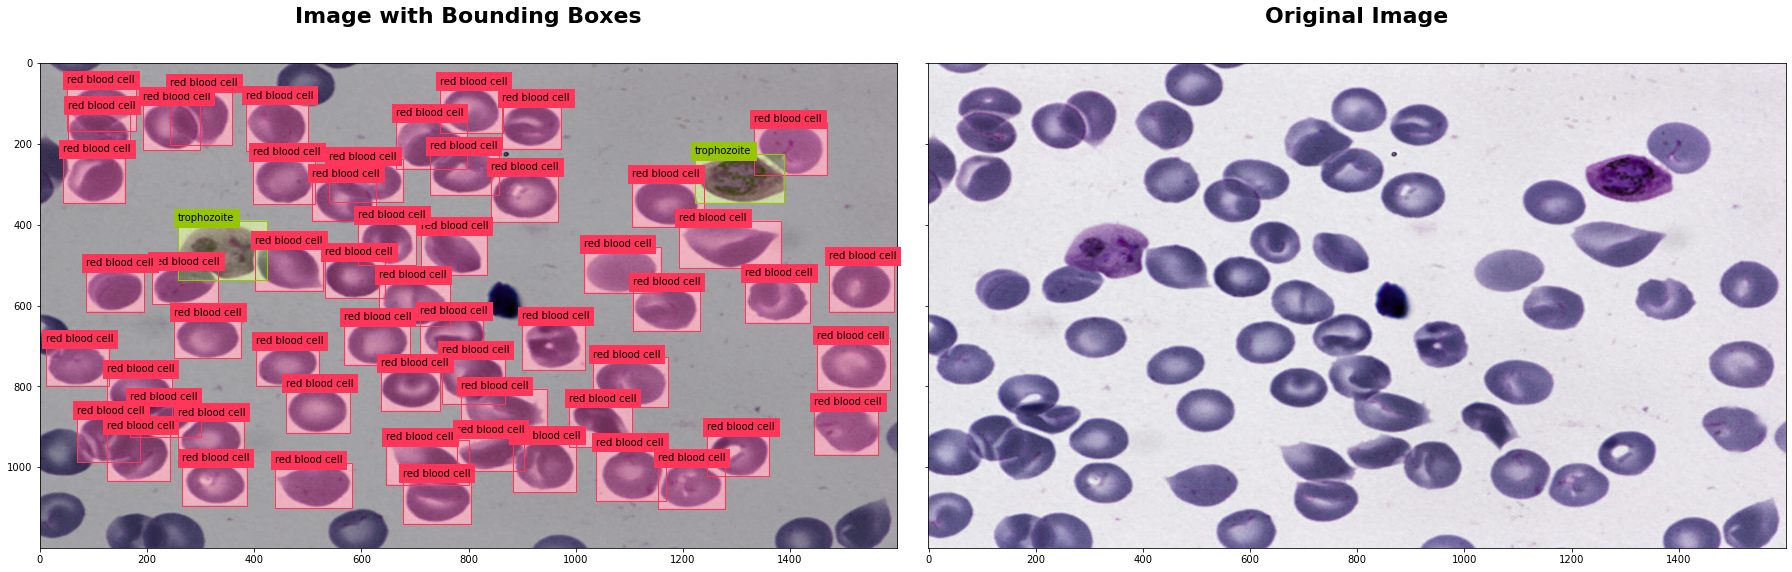

In [98]:
img_path = 'images/065af549-320a-4862-b92a-8ef750d7b5fb.png'
label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}

plot_data_example(df, config.root_dir, img_path, colors=label2hex)

## Prediction

In [50]:
test_df

,score,x_min,y_min,x_max,y_max,label,pathname,category


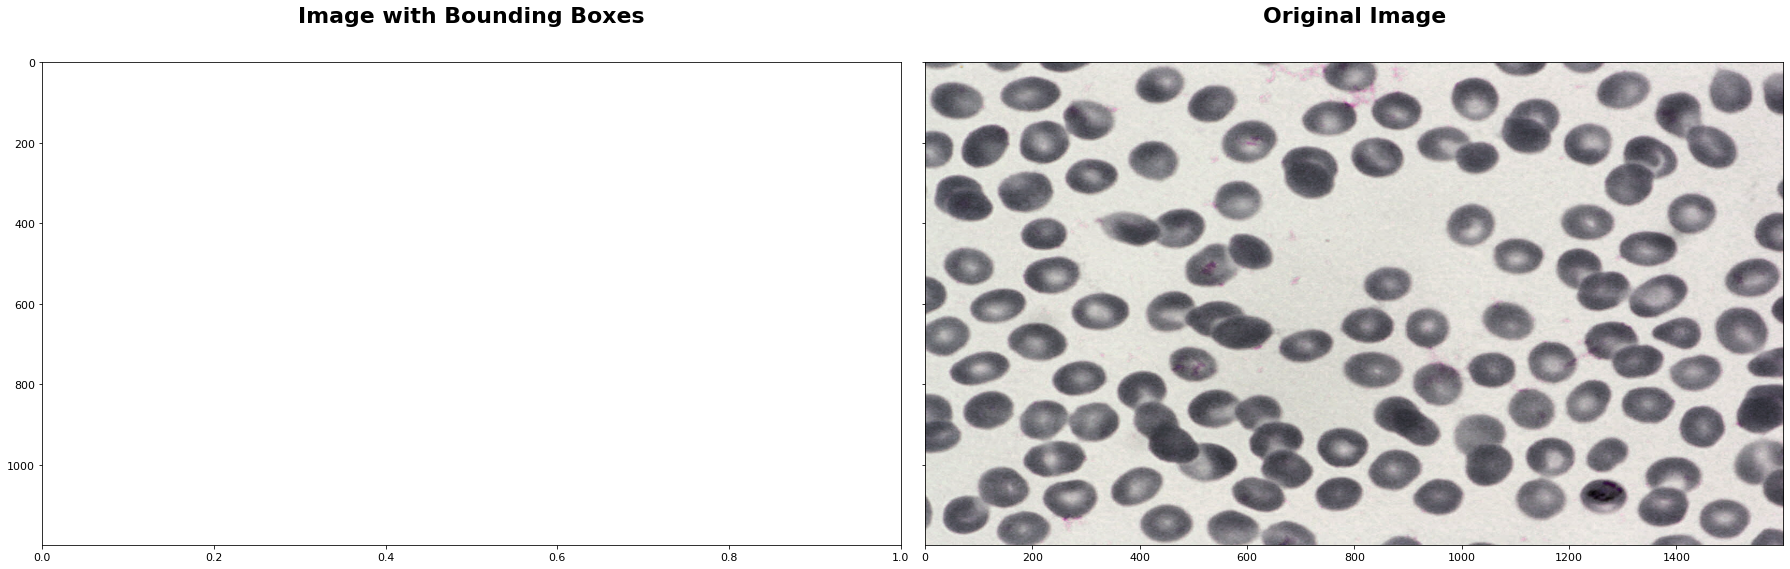

In [51]:
img_path = 'images/a15e0fa8-2620-4f66-896e-175115c9dc3d.png'
label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}

plot_data_example(test_df, config.root_dir, img_path, colors=label2hex)